# <a id='toc1_'></a>[Домашняя-зачетная работа](#toc0_)

Студент(ка): Козлов Максим Дмитриевич

Команда: К07

  - [Постановка задачи](#toc1_1_)    
  - [Подключение библиотек](#toc1_2_)    
  - [Подготовка датасета (15 баллов)](#toc1_3_)    
  - [Архитектура модели (25 баллов)](#toc1_4_)    
  - [Train/val циклы (20 баллов)](#toc1_5_)    
  - [Инициализация остальных параметров и запуск обучения (15 баллов)](#toc1_6_)    
  - [Визуализация результатов (10 баллов)](#toc1_7_)    
  - [Выводы (10 баллов)](#toc1_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Постановка задачи](#toc0_)

Используя знания, полученные на предыдущих практиках предлагается решить одну из предложенные задач, при помощи обучения нейронных сетей:
* Классификация изображений (минимум 5 различных классов);
* Регрессия (например, определять по фотографии возраст/эмоции/гендер);
* Восстановление изображений (при помощи автоэнкодера).

Это примеры задач, ноутбук заточен именно под них. **НО**, если вы хотите сделать что-то своё, что-то новое -- можете делать. Только лучше предварительно согласовать со мной.

Все функции должны быть самописные, начиная от классов для работы с датасетами, заканчивая классами моделей с описанием архитектуры и циклов обучения и верификации.

Т.е. взять и сделать:
```python
from ultralytics import YOLO
```

или

```python
backbone = timm.create_model('mobilenetv3_large_100')
````

не получится :O

Ниже по ноутбуку прописаны разделы и колличество баллов, которое можно получить за качественно выполненный раздел.

Качественно выполненный, имеется ввиду, чтобы он, во-первых, выполнял свою функцию, во-вторых, имел комментарии по ходу, где и что выполняется.

На качество, красоту и оптимизацию кода я НЕ смотрю, главное, чтобы работало и было подробно описано. Поэтому делайте, как вам удобно, и как привыкли, но пишите комментарии.

## <a id='toc1_2_'></a>[Подключение библиотек](#toc0_)

В этом блоке рекомендуется сразу подключить все необходимые для работы библиотеки, я укажу те, которые мы использовали на практиках, и которые, скорее всего, вам и потребуются.

Но, может быть у вас будут еще какие-то, использовать можете всё, что потребуется.

Напоминаю, что если вы работаете в Google Colab, то необходимые библиотеки устанавливаются через следующую команду в ячейке ноутбука.

Локально это тоже работает, в любом ноутбуке, но локально можно и через консоль поставить)

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from torchinfo import summary
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np

# TODO: ваши библиотеки
import torchvision.transforms as transforms
from random import randint

Следующая команда для того, чтобы графики нормально отображались в ячейках ноутбука

In [3]:
%matplotlib inline

## <a id='toc1_3_'></a>[Подготовка датасета (15 баллов)](#toc0_)

Реализовать класс для работы с датасетом, мы делали такое на [практике №4](./Practice_4/Practice4.ipynb).

Класс должен иметь методы `__len__` и `__getitem__`.

Желательно, чтобы при инициализации класса, мы могли передавать в него какие-нибудь параметры, например: количество каналов; размер, к которому приводить изображения; путь до картинок; путь до меток классов; используемые аугментации и тд.

**!!!**

Если вы добавите различные аугментации в класс датасета, это это будут дополнительнные 5 баллов. 

Удобнее это сделать через библиотеку **transforms**, с которой мы уже работали.

А типы аугментаций можно посмотреть по [ссылке](https://pytorch.org/vision/stable/transforms.html).

In [4]:

class WorkDataset(Dataset):
    def __init__(self, data_path, labels, input_channels=3, transform=None):
        """
        Класс WorkDataset представляет набор данных для работы.

        Параметры:
        - data_path (str): Путь к папке с данными.
        - labels (pandas.DataFrame): Датафрейм с метками данных.
        - input_channels (int, optional): Количество каналов входных изображений. По умолчанию 3.
        - transform (callable, optional): Преобразование, применяемое к изображениям. По умолчанию None.
        """
        self.data_path = data_path
        self.labels = labels
        self.input_channels = input_channels
        self.transform = transform

    def __len__(self):
        """
        Возвращает количество элементов в наборе данных.

        Возвращает:
        - int: Количество элементов в наборе данных.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Возвращает элемент набора данных по индексу.

        Параметры:
        - idx (int): Индекс элемента.

        Возвращает:
        - tuple: Кортеж, содержащий изображение и метку.
        """
        fileName = self.labels.iloc[idx, 0]
        target = self.labels.iloc[idx, 1]

        img = Image.open(os.path.join(self.data_path, "images/" +fileName))
        if self.input_channels == 3:
            img = img.convert('RGB')
        else:
            img = img.convert('L')

        if self.transform:
            img = self.transform(img)

        return img, target

Если вы решаете задачу классификации или регрессии, то работать лучше с **csv**-файлом, который содержит метки классов или значения для регрессии, например, для классификации он выглядит следующим образом:

Сначала идет полный путь до файла, затем разделитель, в данном случае это точка с запятой, затем метка класса.

Для регрессии разметка будет такая же, но, метки лучше нормализовать от 0 до 1. Т.е. если вы хотите сделать предсказание возраста, а возраст, допустим от 0 до 80. То вы делите все значения возрастов, что у вас есть на максимальное значение, и у вас будут значения от 0 до 1. 

По идее, так можно сделать с любым датасетом, и под любую задачу, т.е. через регрессию вы можете классифицировать, например, породы кошек или собак. Просто нужно поделить на максимальную метку, которая у вас есть.

## <a id='toc1_4_'></a>[Архитектура модели (25 баллов)](#toc0_)

Реализовать класс для самой модели. Не беритесь за что-то сложное, можно попробовать буквально пару слоёв, а потом при необходимости добавить.

Например, как выглядят простейшие архитектуры моделей для [классификации](https://www.kaggle.com/code/basu369victor/pytorch-tutorial-the-classification) и [регрессии](https://machinelearningmastery.com/building-a-regression-model-in-pytorch/).

Разница между классификацией и регрессией в том, что при классификации вы на выходе получаете вектор логитов (т.е. вероятностей отнесения входных данных к какому-то классу), а при регрессии на выходе у вас будет всего одно число.

In [5]:
class WorkModel(nn.Module):
    def __init__(self):
        """
        Инициализирует объект класса WorkModel.

        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(6400, 256)  # Обновленный размер входного тензора для fc1
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)
        self.dropout_fc = nn.Dropout(0.2)
        self.batchnorm_fc1 = nn.BatchNorm1d(256)
        self.batchnorm_fc2 = nn.BatchNorm1d(128)

    def forward(self, x):
        """
        Выполняет прямой проход (forward pass) через модель.

        Args:
            x (torch.Tensor): Входной тензор размерности (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Выходной тензор размерности (batch_size, num_classes), где num_classes - количество классов.

        """
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = self.pool(x)
        x = self.batchnorm4(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.batchnorm_fc1(x)
        x = self.dropout_fc(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm_fc2(x)
        x = self.dropout_fc(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

## <a id='toc1_5_'></a>[Train/val циклы (20 баллов)](#toc0_)

Реализовать методы для циклов обучения и валидации.

Т.е., бежим по батчам, получаем выход модели, считаем лосс, при обучении: делаем бэквард.

Желательно, во время процесса обучения и валидации выводить значения лосса и аккураси после каждой эпохи. Плюс, строить графики.

In [6]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.val = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0/batch_size))
    return res

def train(model, device, train_loader, criterion, optimizer):
    losses = AverageMeter()
    accs = AverageMeter()

    # switch to train mode
    model.train()

    for _, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)

        # compute output
        output = model(data)
        loss = criterion(output, target)
        
        # measure accuracy
        acc = accuracy(output, target)
        
        # record loss and accuracy
        losses.update(loss.item(), data.size(0))
        accs.update(acc[0], data.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses.avg, accs.avg

In [7]:
def val(model, device, val_loader, criterion):
    losses = AverageMeter()  # Среднее значение потерь
    accs = AverageMeter()  # Среднее значение точности

    # Переключаемся в режим валидации
    model.eval()

    with torch.no_grad():
        for _, (data, target) in enumerate(val_loader):
            target = target.type(torch.LongTensor)
            data, target = data.to(device), target.to(device)

            # Вычисляем выход модели
            output = model(data)
            loss = criterion(output, target)
            
            # Вычисляем точность
            acc = accuracy(output, target)
            
            # Записываем значения потерь и точности
            losses.update(loss.item(), data.size(0))
            accs.update(acc[0], data.size(0))

    return losses.avg, accs.avg

## <a id='toc1_6_'></a>[Инициализация остальных параметров и запуск обучения (15 баллов)](#toc0_)

Инициализируете конфиг, фиксируете сид, подбираете функцию потерь:
* для классификации -- Cross-Entropy;
* для регрессии -- MSE;
* для автоэнкодера -- MSE.

Подбираете метод для подсчета аккураси по время обучения, подбираете гиперпараметры, оптимайзер, шедулер.

Будет круто, если напишите, что и почему выбрали.

In [8]:
config = {
    'batch_size'    : 4, # потому что картинок не так уж и много
    'total_epochs'  : 101,
    'save_epoch'    : 10,
    'learning_rate' : 0.001,
    'data_path'     : 'dataset.csv', # путь до csv-файла
    'save_path'     : 'weights', # путь куда сохранять модельки
    'num_classes'   : 3,
    'input_size'    : 640,
    'input_channels': 3
}

После того, как всё инициализировали можете запускать обучение

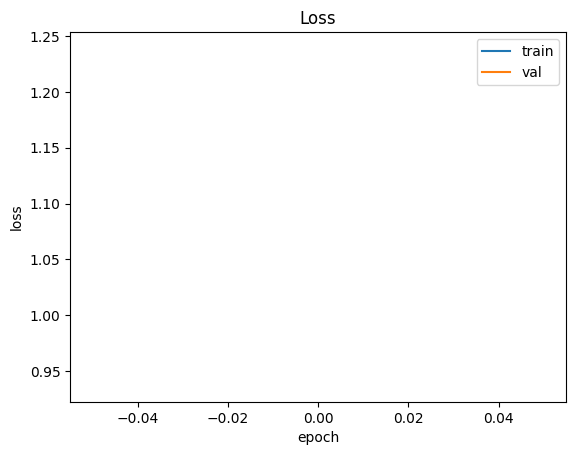

KeyboardInterrupt: 

In [9]:
device = torch.device('cpu')

model = WorkModel()

def load_data(data_path, train_transform, val_transform, input_channels=3):
    # Получаем путь к директории, содержащей файл данных
    path =  os.path.dirname(os.path.abspath(data_path))
    # Загружаем данные обучения из CSV файла
    train_labels = pd.read_csv(data_path, sep=',')

    # Разделяем данные на обучающую и валидационную выборки
    train_labels, valid_labels = train_test_split(train_labels,
                                                  test_size=0.2,
                                                  random_state=random.randint(1, 10000))

    # Сбрасываем индексы данных
    train_labels = train_labels.reset_index(drop=True)
    valid_labels = valid_labels.reset_index(drop=True)

    # Создаем датасеты для обучения и валидации
    train_dataset = WorkDataset(path, train_labels, input_channels, train_transform)
    val_dataset = WorkDataset(path, valid_labels, input_channels, val_transform)

    return train_dataset, val_dataset

# Нормализуем изображения
normalize = transforms.Normalize(mean=[0.498, 0.498, 0.498],
                                std=[0.502, 0.502, 0.502])

# Определяем преобразования для обучающей выборки
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAutocontrast(),
    transforms.ColorJitter(brightness=.1, hue=.1),
    transforms.Resize((config['input_size'], config['input_size'])),
    transforms.ToTensor(),
    normalize,
])

# Определяем преобразования для валидационной выборки
val_transform = transforms.Compose([
    transforms.Resize((config['input_size'], config['input_size'])),
    transforms.ToTensor(),
    normalize,
])

# Загружаем данные
train_dataset, val_dataset = load_data(config['data_path'], train_transform, val_transform, config['input_channels'])

# Создаем загрузчики данных для обучения и валидации
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    drop_last=True
)

# Определяем функцию потерь и оптимизатор
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=config['learning_rate'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Функция для получения текущего learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Хранение логов
log = {"epoch": [], "train_loss": [],  "val_loss": [], "train_acc": [], "val_acc": []}

# Функция для сохранения модели
def save_checkpoint(save_path, state, epoch, tag=''):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    filename = os.path.join(save_path, "{}checkpoint-{:06}.pth.tar".format(tag, epoch))
    torch.save(state, filename)

# Цикл обучения
for epoch in (range(config['total_epochs'])):
    # Обучение модели
    train_loss, train_acc = train(model, device, train_loader, criterion, optimizer)
    # Валидация модели
    val_loss, val_acc = val(model, device, val_loader, criterion)

    # Сохранение модели каждые save_epoch эпох
    if epoch % config['save_epoch'] == 0:
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'loss': val_loss,
            'acc': val_acc,
            'optimizer': optimizer.state_dict(),
            'criterion': criterion.state_dict(),
            'input_shape': (config['input_size'], config['input_size'], config['input_channels']),
            'num_classes': config['num_classes']
        }
        save_checkpoint(config['save_path'], state, epoch, '')

    # Добавление логов
    log['epoch'].append(epoch)
    log['train_loss'].append(train_loss)
    log['val_loss'].append(val_loss)
    
    # Визуализация лосса
    plt.plot(log['epoch'], log['train_loss'], label='train')
    plt.plot(log['epoch'], log['val_loss'], label='val')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss')
    plt.show()

    # Вывод информации о текущей эпохе
    line = '[{}/{}]\t\tLR: {:.2f}\t\tTrain loss: {:.3f}\t\tTrain acc: {:.3f}\t\tVal loss: {:.3f}\t\tVal acc: {:.3f}'.format(
        epoch,
        config['total_epochs']-1,
        get_lr(optimizer),
        train_loss,
        train_acc,
        val_loss,
        val_acc
    )
    
    # Обновление learning rate
    scheduler.step()

## <a id='toc1_7_'></a>[Визуализация результатов (10 баллов)](#toc0_)

После того, как получили модель с достаточным качеством, нужно показать, как она работает.

Визаулизируйте данные, которые подаёте на вход, какой выход модели. Можно даже собрать тестовый датасет и посчитать на нём метрики, кроме тех, что считали во время обучения.

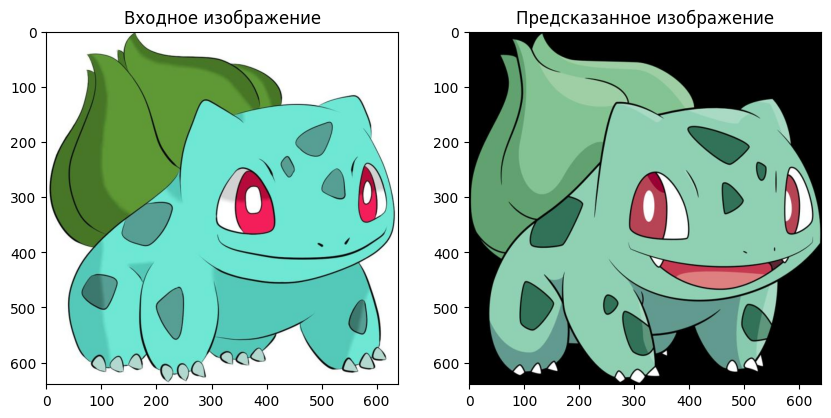

In [12]:
classes = ["bulbazaur", "charmander", "pikachu"]
classes_pics = ["bulbazaur-5.jpg", "charmander-5.jpg", "pikachu-5.jpg"]
classes_to_check_pics = ["bulbazaur-test.jpg", "charmander-test.jpg", "pikachu-test.jpg"]

model_path = 'weights/checkpoint-000100.pth.tar'

import torch

# Загрузка сохраненной модели
checkpoint = torch.load(model_path, device)
inf_backbone = WorkModel().to(device)
inf_backbone.load_state_dict(checkpoint['state_dict'])
inf_backbone.eval()

# Выбор случайного изображения для тестирования
test_data_path = classes_to_check_pics[randint(0, 2)]
pil_img = Image.open(f"images/{test_data_path}").convert('RGB')
img = np.expand_dims(np.array(val_transform(pil_img)), 0)

data = torch.tensor(img, dtype=torch.float32, device=device).to(device)
output = inf_backbone(data)
soft_output = torch.softmax(output, dim=-1)
_, predicted = torch.max(soft_output.data, 1)
confidence = soft_output[0][predicted[0]]
predicted = predicted.to(device).cpu().detach().numpy()[0]

plt.figure(figsize=(10, 5))

# Отображение входного изображения
plt.subplot(1, 2, 1)
plt.imshow(pil_img)
plt.title('Входное изображение')

from PIL import Image

# Отображение предсказанного изображения
predicted_img_path = classes_pics[predicted]  # предполагая, что classes_pics содержит пути к изображениям
predicted_img = Image.open(f"images/{predicted_img_path}").convert('RGB')

plt.subplot(1, 2, 2)
plt.imshow(predicted_img)
plt.title('Предсказанное изображение')

plt.show()



## <a id='toc1_8_'></a>[Выводы (10 баллов)](#toc0_)

Пишите всё, с чем столкнулись во время работы, что выбирали и почему, что получилось, а что не очень. Чем более полные будут выводы, тем больше вероятность того, что вы получите максимальный балл.

не люблю использовать ipynb файлы, вылезли проблемы с импортами, фантомные)

сложность заключалась в mat1 mat2 расчетах и пониманиях что за что отвечает, в сборе датасета, понимании задачи, еще уверен что даже то, что имеется сейчас очень плохо обучается. разбираться еще с колабой чтобы использвовать большие вычислительные мощности - не хочется, поэтому качественно протестировать изменения числа batch_size я не смогу. в принципе резульататом доволен, покемонов угадывает, если бы еще их было больше и трейн дат картинок было больше было бы поинтереснее. покемонов выбрал потому что очень много в свое время играл в майнкрафт на лаунчерах с набором модов пиксельмон, но в это же время само аниме покемонов я не смотрел)) вот так вот. всегда выбирал как начального покемона сквиртла, а все выбирали чаризарда и охотились за пикачу, в принципе все рассказал, курс интересные, ЖК 